## Coadd using Legacy Code Translated from Fortran77

In [1]:
import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

import testing functions from `../src/`

In [2]:
sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper

### Prepare Data

#### Read cutout paths

Naming convention of single images:

```
           "xxx_path"          
|-----------------------------|
/path/to/the/file/filename.fits
|----------------|------------|
    "xxx_dir"      "xxx_name"  
                               
xxx_data = array([[...]])      
```


Naming convention of lists:
```
xxx_paths = [xxx_path, xxx_path, ...]
xxx_names = [xxx_name, xxx_name, ...]
xxx_atlas = [xxx_data, xxx_data, ...]
```

In [23]:
cutout_dir = '/quasar/yichenliu/cutout_f430m'
cutout_paths = []
cutout_names = os.listdir(cutout_dir)
for cutout_name in cutout_names: 
    cutout_path = os.path.join(cutout_dir, cutout_name)
    cutout_paths.append(cutout_path)
cutout_paths.sort()

cutout_paths

['/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00001_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00002_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00003_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00004_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00005_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00006_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00007_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00008_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f430m/jw01764001001_06101_00009_nrcblong_cal_bsub_aligned_cutout.fits']

#### Load images

In [50]:
orig_atlas = []
for cutout_path in cutout_paths: 
    with fits.open(cutout_path) as hdul: 
        data = hdul[1].data
        orig_atlas.append(data)

#### Get the offsets

Find the brightest pixel near the center

In [54]:
brightest_xys = []
for data in orig_atlas: 
    xy = dutils.get_brightest_pixel(data, 50, 100, 50, 100) # some random limits
    brightest_xys.append(xy)
brightest_xys = np.array(brightest_xys)

brightest_xys

array([[76, 76],
       [80, 78],
       [79, 80],
       [77, 76],
       [76, 76],
       [76, 76],
       [77, 76],
       [77, 75],
       [76, 76]])

pad the images to align its centers

In [55]:
pad = dutils.calculate_padding_radius(brightest_xys)

aligned_atlas = []
for i in range(9):
    data = orig_atlas[i]
    brightest_xy = brightest_xys[i]
    aligned_data = dutils.pad_image_with_centroid(data, pad, brightest_xy)
    aligned_atlas.append(aligned_data)

Calculate the centroids by averaging up the pixels within the central area using `centroid_com` in `Photutils`

In [56]:
cx, cy = dutils.get_pixel_center_from_array(orig_atlas[0])
r = 5

centroids = []
for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_centroid_com(data, cx, cy, r)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]
centroids

array([[ 0.177,  0.219],
       [-0.093, -0.506],
       [-0.493, -0.333],
       [-0.333, -0.418],
       [ 0.13 , -0.209],
       [-0.158,  0.061],
       [-0.052, -0.099],
       [-0.561,  0.19 ],
       [ 0.085,  0.347]])

A more proper way is to perform a source detection using `DAOStarFinder` in `Photusils`. These two methods have on average 6% difference. 

In [57]:
centroids = []

for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_DAOStarFinder(data, cx, cy)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]

centroids

array([[ 0.408,  0.29 ],
       [ 0.067, -0.52 ],
       [-0.337, -0.292],
       [-0.185, -0.444],
       [ 0.37 , -0.184],
       [ 0.053,  0.11 ],
       [ 0.11 , -0.054],
       [-0.447,  0.198],
       [ 0.275,  0.451]])

Visually check the center

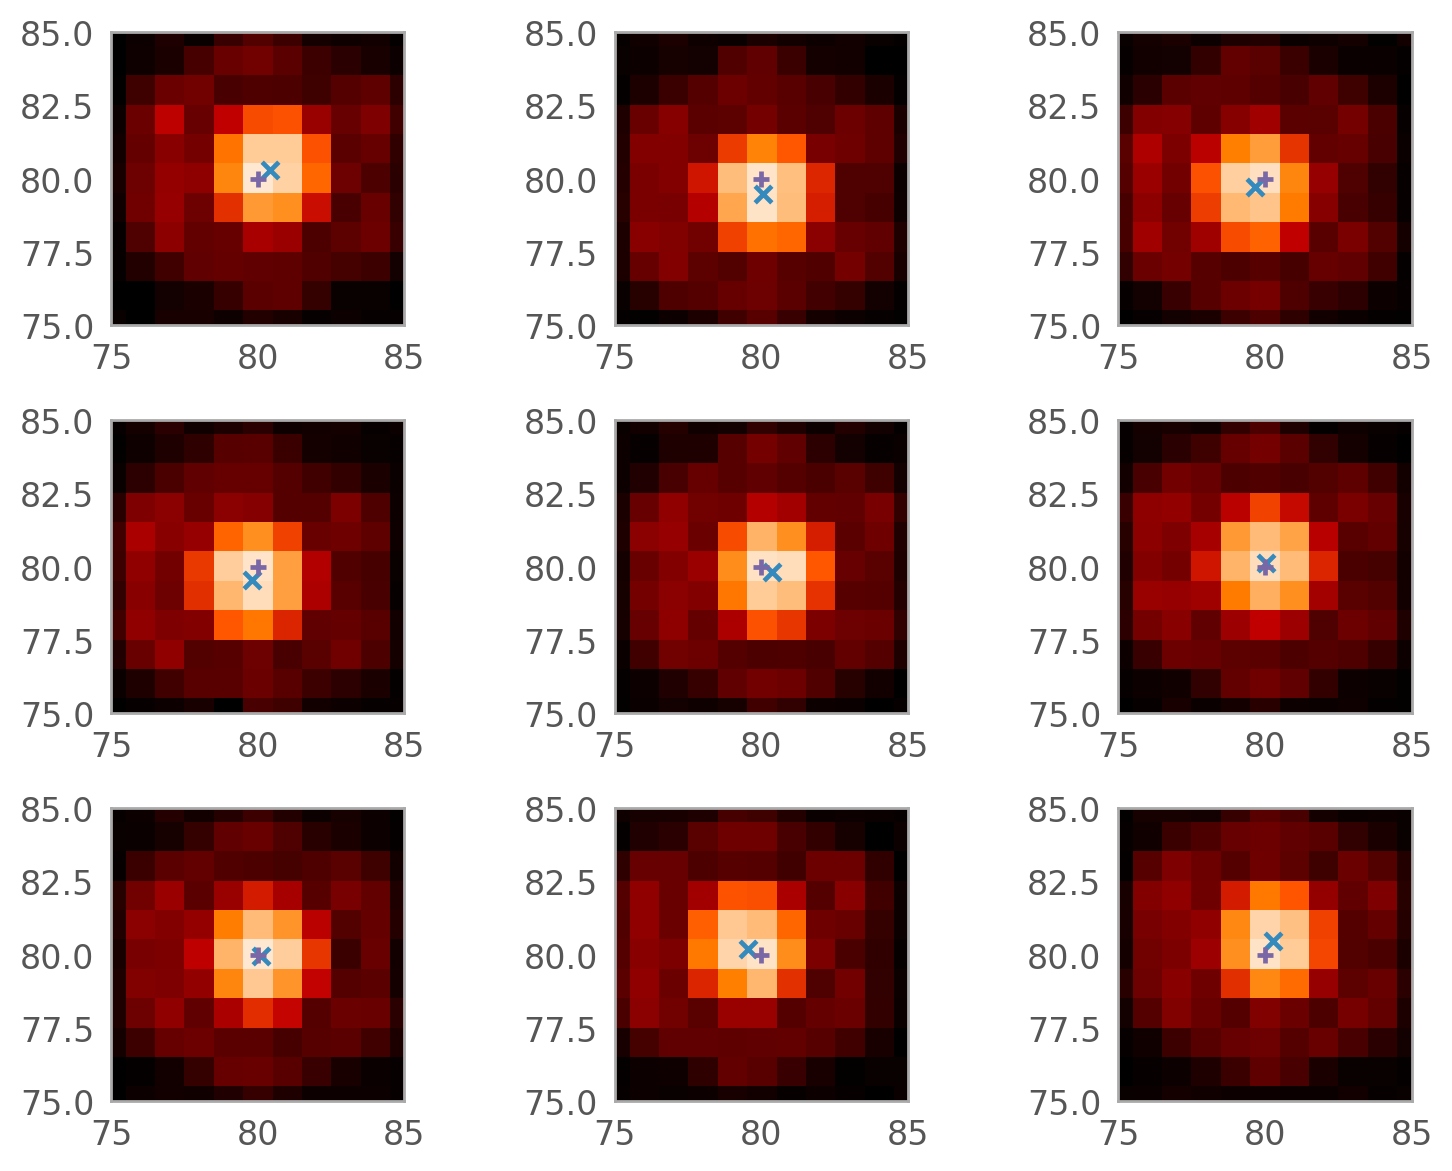

In [58]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=5)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

#### Mask out cosmic rays

The AGN is excluded by counting the number of connected pixels

In [59]:
masks = []

for i in range(9):
    data = aligned_atlas[i]
    mask = dutils.get_cosmic_ray_mask_without_AGN(data, kernel_size=3, sigma_threshold=40, max_connected_pixels=16)
    masks.append(mask)

Mask them out by setting them to 0 because the image is already background subtracted

In [60]:
aligned_atlas_masked = []
for i in range(9): 
    data_masked = aligned_atlas[i].copy()
    mask = masks[i]
    data_masked[mask] = 0
    aligned_atlas_masked.append(data_masked)

Visually check the mask

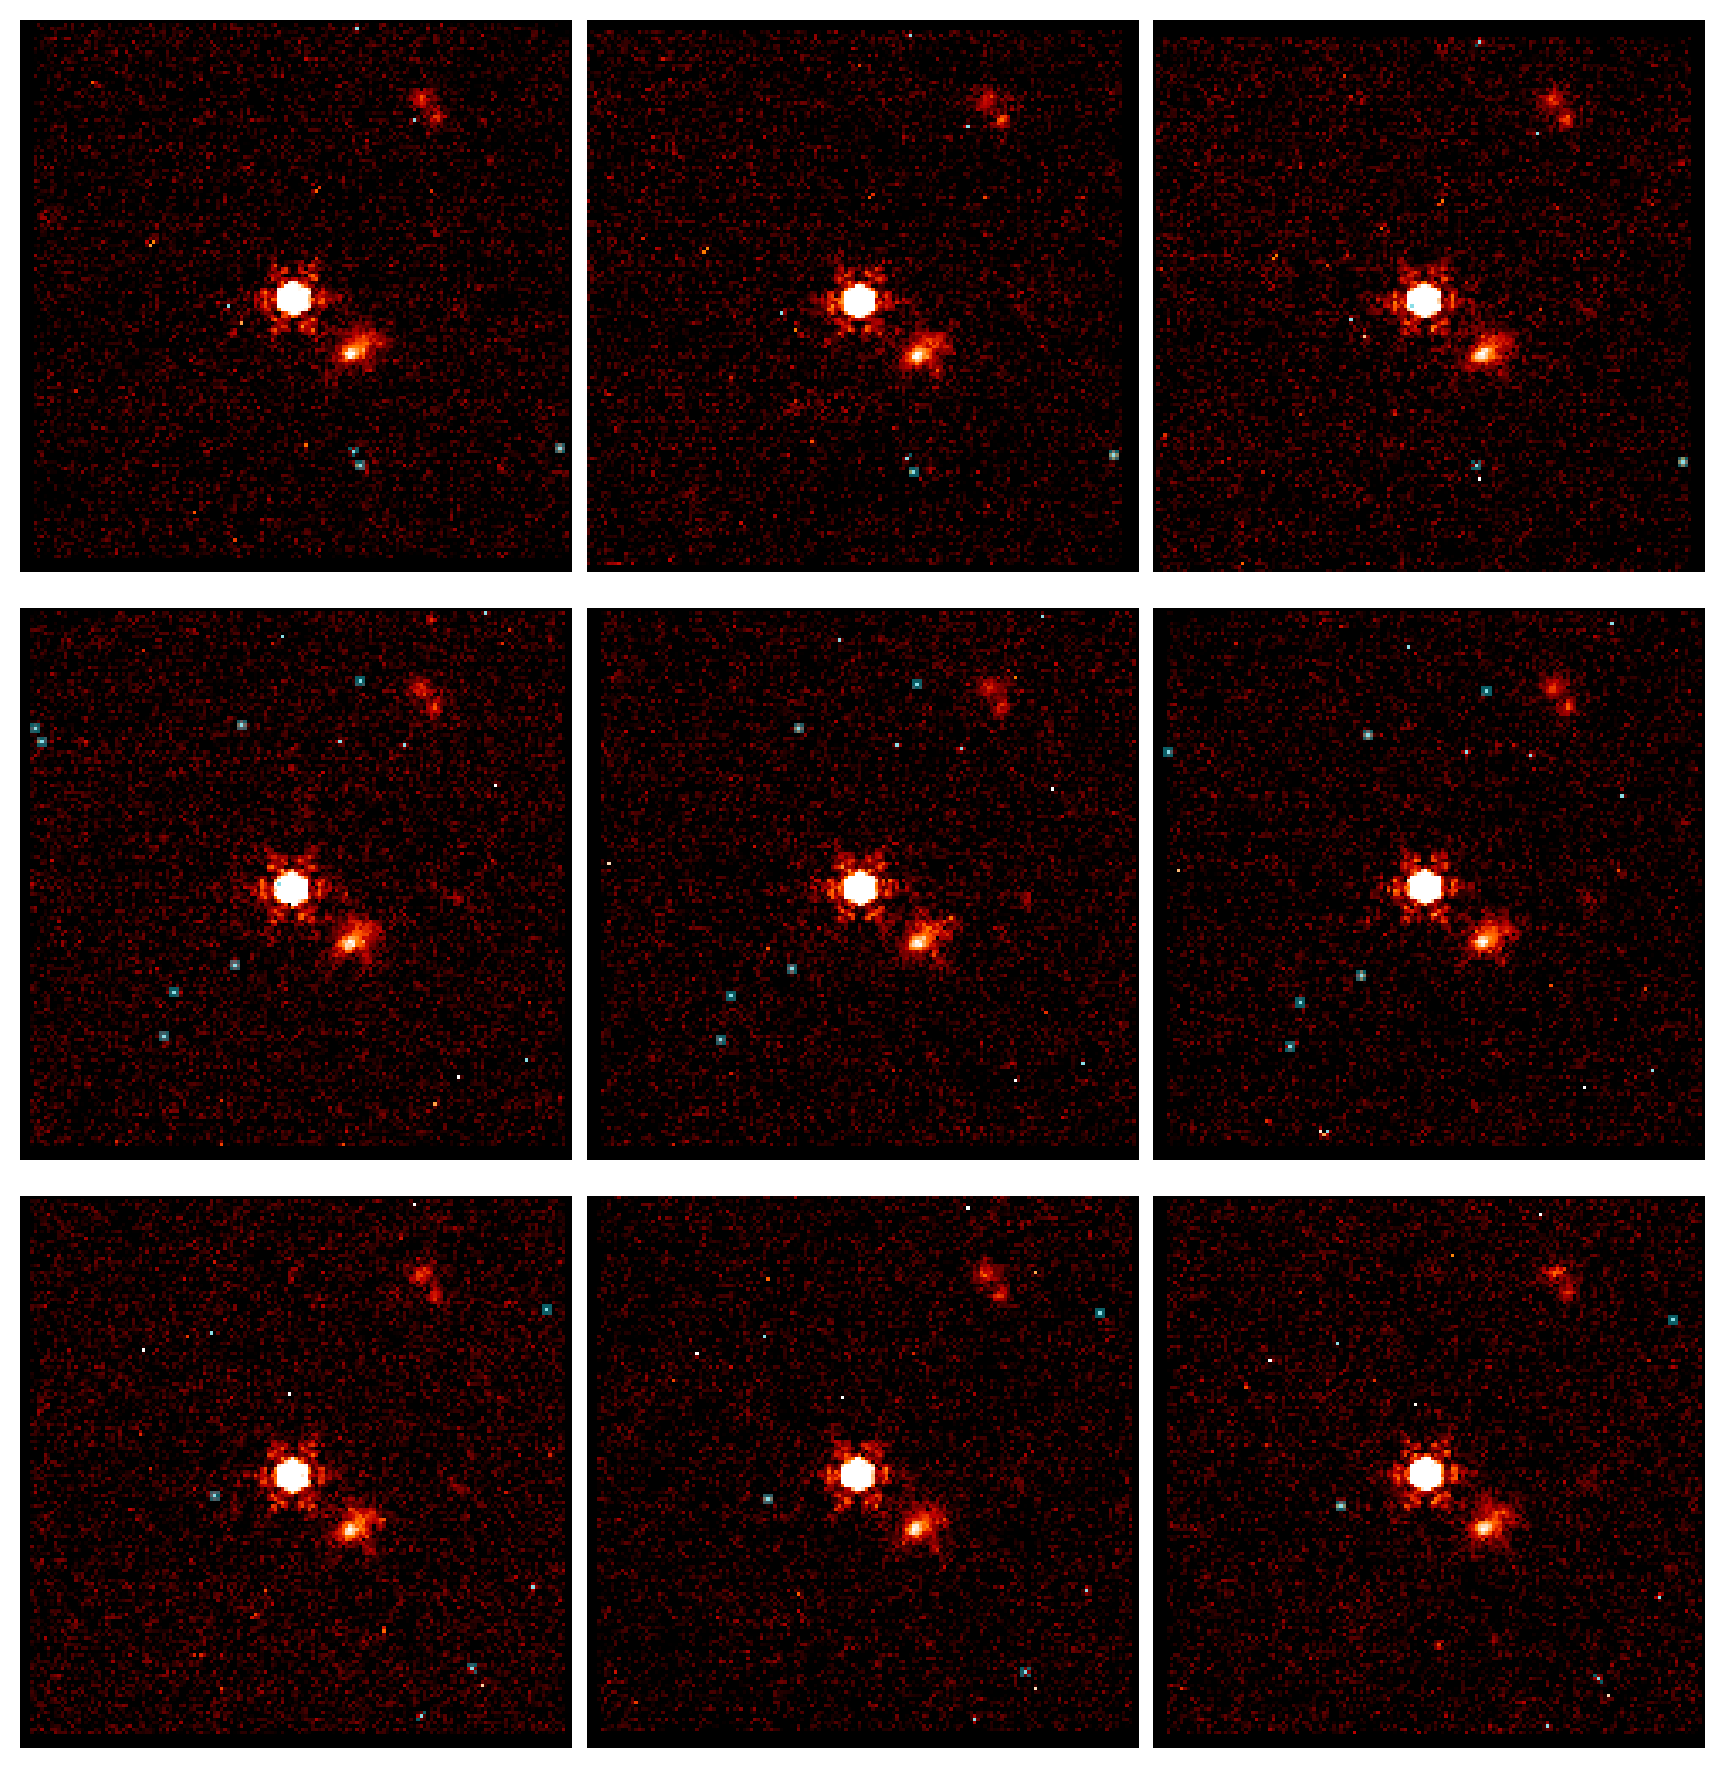

In [61]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    mask = masks[i]
    axs[i].imshow(stretch(data), vmin=0, vmax=1)
    axs[i].imshow(mask, cmap=plt.get_cmap('tab10'), alpha=mask*0.5)
    axs[i].grid(False)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Coadd Images Using Updated Code

change ft

In [62]:


NC_FREQ = 514 # must be 2**N + 2
NR_FREQ = 512 # must be 2**N
NC_SPAT = NC_FREQ
NR_SPAT = NR_FREQ # must be 2**N


def real2dfft(a, nra, nca, b, nrb, ncb, isign, work, onedim=False):
    a = a.copy()
    b = b.copy()
    work = np.zeros((2, max(nra, nrb)))
    if isign >= 0:
        # print(a.shape, b.shape, nrb, ncb, a[:6, :nrb].shape)
        a[:ncb, :nrb] = b
        a[ncb:, :] = 0
        nhc = (nca - 2)//2
        # print(nhc)
        for ir in range(nrb):
            a[:, ir] = realft(a[:, ir], nhc, isign)
        # print(a)
        # print(a[0, :].size, nhc)
        # a[0, :] = realft(a[0, :], nhc, isign)
        if onedim:
            return a
        for ic in range(1, nca+1, 2):
            # print('ic', ic, a[ic+1-1, :nrb])
            # print(a)
            work[0, :nrb] = a[ic-1, :nrb]
            work[1, :nrb] = a[ic+1-1, :nrb]
            work[:, nrb:] = 0
            # print('work', 'nra', nra)
            work = four1(work.T.flatten(), nra, isign).reshape(-1, 2).T
            # print(work)
            a[ic-1, :] = work[0, :]
            a[ic+1-1, :] = work[1, :]
    else:
        if not onedim:
            for ic in range(1, ncb+1, 2):
                work[0, :nrb] = b[ic-1, :nrb]
                work[1, :nrb] = b[ic+1-1, :nrb]
                # print('work2', 'nra', nra)
                work = four1(work.T.flatten(), nra, isign).reshape(-1, 2).T
                b[ic-1, :] = work[0, :]
                b[ic+1-1, :] = work[1, :]
        nhc = (ncb - 2)//2
        for ir in range(nra):
            b[:, ir] = realft(b[:, ir], nhc, isign)
        if onedim:
            tmp = 1.0/nhc
        else:
            tmp = 1.0/(nrb*nhc)
        a[:nca, :nra] = b[:nca, :nra]*tmp
    return a



def fft(data): 
    b = np.zeros((NC_SPAT, NR_SPAT))
    b[:data.shape[0], :data.shape[1]] = data
    # b[100:200, 100:200] = data_large[100:200, 100:200]
    a = np.zeros((NC_FREQ, NR_FREQ))
    isign = 1
    work = np.zeros((2, NR_SPAT))
    data_hat = real2dfft(a, NR_FREQ, NC_FREQ, b, NR_SPAT, NC_SPAT, isign, work, onedim=False)
    # plt.imshow(norm(orig_hat))
    # plt.colorbar()
    return data_hat

def ifft(data_hat): 
    b = np.zeros((NC_FREQ, NR_FREQ))
    b[:data_hat.shape[0], :data_hat.shape[1]] = data_hat
    # b[100:200, 100:200] = data_large[100:200, 100:200]
    a = np.zeros((NC_SPAT, NR_SPAT))
    isign = -1
    work = np.zeros((2, NR_FREQ))
    data = real2dfft(a, NR_SPAT, NC_SPAT, b, NR_FREQ, NC_FREQ, isign, work, onedim=False)
    # plt.imshow(norm(orig_hat))
    # plt.colorbar()
    return data


import scipy

# updated four1()

def four1_forward(a): 
    a_complex = a[::2]+a[1::2]*1j
    a_hat_complex = scipy.fft.fft(a_complex)
    a_hat_real = a_hat_complex.real
    a_hat_imag = a_hat_complex.imag
    a_hat = np.zeros(len(a))
    a_hat[0] = a_hat_real[0]
    a_hat[1] = a_hat_imag[0]
    a_hat[2::2] = a_hat_real[-1:0:-1]
    a_hat[3::2] = a_hat_imag[-1:0:-1]
    return a_hat

def four1_backward(a_hat): 
    a_hat_real = np.zeros(len(a_hat)//2)
    a_hat_imag = np.zeros(len(a_hat)//2)
    a_hat_real[-1:0:-1] = a_hat[2::2]
    a_hat_imag[-1:0:-1] = a_hat[3::2]
    a_hat_real[0] = a_hat[0]
    a_hat_imag[0] = a_hat[1]
    a_hat_complex = a_hat_real + a_hat_imag*1j
    a_complex = scipy.fft.ifft(a_hat_complex)
    a = np.zeros(len(a_hat))
    a[::2] = a_complex.real
    a[1::2] = a_complex.imag
    a *= len(a_hat)//2
    return a

from dither.legacy import four1

a = np.random.rand(128)
print(a)
a_hat = four1_forward(a)
print(a_hat)
a_hat = four1(a, nn=64, isign=1)
print(a_hat)
# ap = four1(a_hat, nn=4, isign=-1)
# print(ap)
# a = np.arange(128)
# # a = np.array([4, 56, 5, 32, 5, 6, 4, 4.])
# # print(a[::2])
# # a = np.random.rand(8)

# print(a)
ap = four1(a_hat, nn=64, isign=-1)

# print(a)
a_prime = four1_backward(a_hat)


ap/64 - a_prime/64


[0.61  0.951 0.227 0.287 0.898 0.731 0.162 0.26  0.838 0.444 0.087 0.769
 0.112 0.505 0.387 0.378 0.662 0.343 0.479 0.911 0.894 0.245 0.718 0.379
 0.845 0.668 0.73  0.471 0.567 0.694 0.529 0.78  0.118 0.684 0.88  0.288
 0.197 0.957 0.276 0.227 0.635 0.533 0.134 0.168 0.829 0.466 0.105 0.527
 0.816 0.674 0.754 0.8   0.734 0.209 0.273 0.625 0.78  0.457 0.386 0.998
 0.14  0.315 0.913 0.333 0.246 0.15  0.59  0.51  0.501 0.403 0.18  0.612
 0.563 0.309 0.01  0.603 0.123 0.328 0.406 0.027 0.131 0.739 0.654 0.116
 0.803 0.235 0.143 0.481 0.838 0.64  0.906 0.499 0.684 0.993 0.725 0.243
 0.754 0.911 0.459 0.242 0.539 0.893 0.714 0.304 0.943 0.592 0.984 0.803
 0.598 0.442 0.568 0.073 0.121 0.415 0.423 0.121 0.564 0.297 0.009 0.076
 0.663 0.222 0.65  0.09  0.848 0.98  0.214 0.536]
[33.271 30.964 -0.448 -0.735 -3.627 -2.547 -3.874  3.225  1.164  0.147
  1.835  1.5    2.516  0.704  2.274  0.204  0.233  0.828 -3.217  0.837
 -0.001  1.109  1.111  2.188 -0.233 -2.632  0.603  1.642 -1.158 -0.781
 -0.519

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
        0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
        0.,  0., -0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,
        0., -0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.])

In [63]:
%%time
a = np.random.rand(2**20)

a_hat = four1_forward(a)
a_prime = four1_backward(a_hat)

CPU times: user 57.2 ms, sys: 54 μs, total: 57.3 ms
Wall time: 54.3 ms


In [34]:
%%time
a = np.random.rand(2**20)

a_hat = four1(a, 2**19, 1)
a_prime = four1(a_hat, 2**19, -1)

CPU times: user 13 s, sys: 0 ns, total: 13 s
Wall time: 13 s


In [35]:
def realft_forward(a): 
    n = len(a)
    nn = (len(a) - 2)//2
    a_hat_complex = np.fft.fft(a[:nn*2])
    a_hat_real = a_hat_complex.real
    a_hat_imag = a_hat_complex.imag
    a_hat = np.zeros(n)
    a_hat[::2] = a_hat_real[:nn+1]
    a_hat[1::2] = -a_hat_imag[:nn+1]
    return a_hat

def realft_backward(a_hat): 
    nn = (len(a_hat) - 2)//2
    a_hat_real = np.zeros(nn*2)
    a_hat_real[:nn+1] = a_hat[0::2]
    a_hat_real[nn+1:] = a_hat[2:-2:2][::-1]
    a_hat_imag = np.zeros(nn*2)
    a_hat_imag[:nn+1] = -a_hat[1::2]
    a_hat_imag[nn+1:] = a_hat[3:-1:2][::-1]
    a_complex = a_hat_real + a_hat_imag*1j
    a = np.fft.ifft(a_complex)
    a = np.concatenate((a, [0]*2))
    a = a.real
    a *= nn
    return a

from dither.legacy import realft

a = np.random.rand(130)
print(a)
a_hat = realft_forward(a)
# print(a_hat2.real)
# print(a_hat2.imag)
# print(a_hat)
# print()

ap = realft_backward(a_hat)

app = realft(a_hat, 64, -1)

ap/8 - app/8

[0.31  0.64  0.293 0.16  0.295 0.827 0.892 0.594 0.213 0.851 0.242 0.773
 0.258 0.567 0.126 0.43  0.87  0.379 0.29  0.874 0.297 0.061 0.832 0.553
 0.457 0.098 0.66  0.893 0.587 0.192 0.762 0.298 0.769 0.111 0.637 0.754
 0.98  0.221 0.831 0.693 0.883 0.647 0.522 0.226 0.194 0.187 0.787 0.345
 0.413 0.634 0.245 0.134 0.396 0.028 0.953 0.878 0.176 0.137 0.528 0.726
 0.058 0.127 0.173 0.397 0.431 0.328 0.29  0.636 0.039 0.54  0.378 0.955
 0.034 0.824 0.743 0.688 0.744 0.307 0.759 0.351 0.761 0.293 0.043 0.823
 0.82  0.343 0.518 0.839 0.54  0.975 0.167 0.392 0.158 0.66  0.983 0.945
 0.984 0.219 0.384 0.855 0.923 0.995 0.508 0.427 0.077 0.861 0.013 0.28
 0.441 0.536 0.722 0.29  0.508 0.983 0.947 0.163 0.4   0.337 0.838 0.024
 0.428 0.232 0.948 0.18  0.829 0.02  0.823 0.731 0.655 0.346]


array([ 0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   , -0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,
        0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   , -0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
        0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,
       -0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   , -0.   ,
        0.   ,  0.   , -0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ,
        0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
        0.   ,  0.   , -0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ,
       -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,
        0.   ,  0.   , -0.   ,  0.   ,  0.   , -0.   ,  0.   ,  0.   ,
        0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   , -0.   , -0.   ,
        0.   , -0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   , -0.   ,
      

In [36]:
%%time
a = np.random.rand(2**20+2)

a_hat = realft_forward(a)
a_prime = realft_backward(a_hat)

CPU times: user 70.9 ms, sys: 28 ms, total: 98.9 ms
Wall time: 97.2 ms


In [37]:
%%time
a = np.random.rand(2**20+2)

a_hat = realft(a_hat, 2**19, 1)
a_prime = realft(a_hat, 2**19, -1)

CPU times: user 13.6 s, sys: 0 ns, total: 13.6 s
Wall time: 13.6 s


In [38]:
from dither.legacy import real2dfft
from dither.wrapper import fft, ifft


def real2dfft_forward(data):
    nc, nr = data.shape
    data_hat = data.copy()
    for ir in range(nr):
        data_hat[:, ir] = realft_forward(data_hat[:, ir])
    for ic in range(0, nc, 2):
        row = np.zeros(nr*2)
        row[0::2] = data_hat[ic, :]
        row[1::2] = data_hat[ic+1, :]
        row_hat = four1_forward(row)
        data_hat[ic, :] = row_hat[0::2]
        data_hat[ic+1, :] = row_hat[1::2]
    return data_hat

def real2dfft_backward(data):
    nc, nr = data.shape
    data_hat = data.copy()
    for ic in range(0, nc, 2):
        row = np.zeros(nr*2)
        row[0::2] = data_hat[ic, :]
        row[1::2] = data_hat[ic+1, :]
        row_hat = four1_backward(row)
        data_hat[ic, :] = row_hat[0::2]
        data_hat[ic+1, :] = row_hat[1::2]
    for ir in range(nr):
        data_hat[:, ir] = realft_backward(data_hat[:, ir])
    data_hat /= nr*(nc - 2)//2
    return data_hat

NC, NR = 6, 4
wrapper.set_padding_size(NC, NR)

data = np.random.rand(NC, NR)
print(data)
data_hat = fft(data)
print(data_hat)

data_hat1 = ifft(data_hat)

data_hat2 = real2dfft_backward(data_hat)

data_hat1, data_hat2
data_hat1 - data_hat2, 

[[0.533 0.99  0.629 0.895]
 [0.029 0.959 0.58  0.599]
 [0.578 0.145 0.268 0.484]
 [0.436 0.181 0.726 0.779]
 [0.624 0.248 0.074 0.059]
 [0.87  0.61  0.715 0.717]]
[[ 8.812 -0.627 -1.255 -0.627]
 [ 0.    -0.482  0.     0.482]
 [ 1.571 -1.364 -0.94   0.551]
 [ 0.045  0.174 -1.152 -0.694]
 [ 0.234  1.055  0.241  1.055]
 [ 0.    -0.006  0.     0.006]]


(array([[-0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   ,  0.   ],
        [ 0.556,  0.568,  0.448,  0.69 ],
        [ 0.232,  0.57 ,  0.653,  0.689]]),)

In [39]:
%%time
a = np.random.rand(2**10+2, 2**10)

a_hat = real2dfft_forward(a)
a_prime = real2dfft_backward(a_hat)

CPU times: user 96.8 ms, sys: 0 ns, total: 96.8 ms
Wall time: 95.1 ms


In [40]:
NC, NR = 2**10+2, 2**10
wrapper.set_padding_size(NC, NR)

In [41]:
%%time
a = np.random.rand(2**10+2, 2**10)

a_hat = fft(a)
a_prime = ifft(a_hat)

CPU times: user 14.4 s, sys: 3.98 ms, total: 14.4 s
Wall time: 14.4 s


[[ 0.29   0.408  1.   ]
 [-0.52   0.067  1.   ]
 [-0.292 -0.337  1.   ]
 [-0.444 -0.185  1.   ]
 [-0.184  0.37   1.   ]
 [ 0.11   0.053  1.   ]
 [-0.054  0.11   1.   ]
 [ 0.198 -0.447  1.   ]
 [ 0.451  0.275  1.   ]]
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Image 1, power (0.42341913282209204-0.06566946973031233j), sector 1
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Image 1, power (0.32083606766637784+0.11977732711479441j), sector 2
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Fundamental 1
Image 2, power (0.34172863110925294+0.03748567767814088j), sector 1
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Fundamental 3
Image 2, power (0.4659608548751204-0.04592687781466259j), sector 2
Fundamen

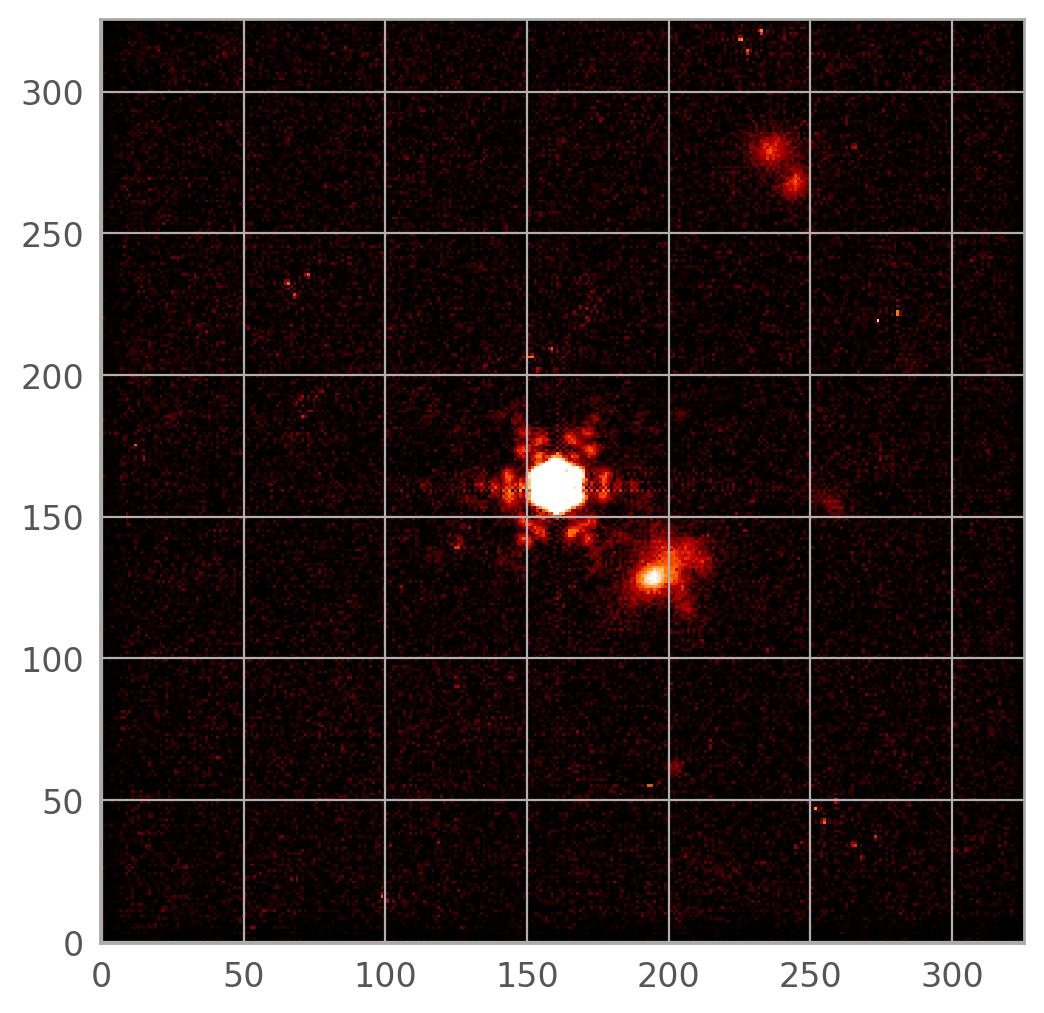

In [91]:
PI = np.pi
RADIOAN = PI/180
NSTMAX = 140
NDIV = 3

from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2

def phase_updated(A_in, offsets, npos):
    A = A_in.copy()
    phix = np.zeros(NSTMAX)
    phasem = np.zeros((NDIV**2, NDIV**2), dtype=np.complex128)
    vec = np.zeros((NDIV**2, NDIV**2), dtype=np.complex128)
    coef = np.zeros((NDIV**2), dtype=np.complex128)
    phases = np.zeros((NDIV**2, NSTMAX), dtype=np.complex128)
    key = np.zeros(NDIV**2)
    
    # LINE 247 - read offsets (totally different from the original code)

    offsets = np.array(offsets)
    xcr = offsets[0, 0]
    ycr = offsets[0, 1]
    dx = offsets[:, 0] - xcr
    dy = offsets[:, 1] - ycr
    phix = NSUB*PI*dx
    phiy = NSUB*PI*dy
    wt = offsets[:, 2]
    npp = len(offsets)

    # LINE 289 - Calculate the coefficients for each image. 

    nsy = NSUB # 2
    nsx = (NSUB - 1)//2 + 1 # 1
    isy = -((NSUB-1)//2) + 1 # 0, NOTE: added a bracket to regulate different handling of integer division
    isy = 0
    isec = 0

    for iy in range(isy, isy+nsy): 
        for ix in range(0, nsx): 

            isec += 1

            # LINE 304

            for nim in range(npp):
                px = -phix[nim]*2/NSUB
                py = -phiy[nim]*2/NSUB
                nuin = ix - (NSUB - 1)//2
                nvin = iy
                pxi = nuin*px
                pyi = -nvin*py

                isat = 0
                for isaty in range(0, NSUB):
                    for isatx in range(0, NSUB): 
                        isat += 1
                        phit = isatx*px + pxi + isaty*py + pyi
                        phases[isat-1, nim] = (np.cos(phit) + np.sin(phit)*1j)/NSUB**2

                # LINE 344 - Pivot if required so that the fundamental is always in column 1

                nfund = 1 + NSUB*nvin - nuin
                print('Fundamental', nfund)
                temp = phases[0, nim]
                phases[0, nim] = phases[nfund-1, nim]
                phases[nfund-1, nim] = temp

            # LINE 355 - This loads an identity matrix, which will be used to invert the phase matrix.
            
            vec = np.eye(NDIV**2, dtype=np.complex128)
            key = np.arange(NSUB**2) + 1
            
            # print(phases)
            # vec[:9, :4] = la.pinv(phases[:4, :9])

            ### BEGIN MATRIX INVERSION

            # LINE 367 - If N>nsub2, then the problem is over determined

            # LINE 371 - The weighting factor is used at this point.

            if npp>NSUB**2: 
                # print('npp>NSUB**2')
                for i in range(1, NSUB**2+1): 
                    for j in range(1, NSUB**2+1): 
                        phasem[j-1, i-1] = 0+0j
                        for k in range(1, npp+1): 
                            phasem[j-1, i-1] += np.conj(phases[i-1, k-1])*wt[k-1]*phases[j-1, k-1]
            else: 
                for i in range(1, NSUB**2+1): 
                    for j in range(1, NSUB**2+1): 
                        phasem[j-1, i-1] = phases[j-1, i-1]

            # LINE 391 - solve for the data vector phases

            for i in range(1, NSUB**2-1+1): 
                for j in range(i+1, NSUB**2+1): 

                    # LINE 396 - Check for zero division and pivot if required.

                    if (phasem[i-1, i-1]*np.conj(phasem[i-1, i-1])==0): 
                        pivot = False
                        k = i+1
                        while (not pivot) and (k<=NSUB**2): 
                            if (phasem[i-1, k-1]*np.conj(phasem[i-1, k-1])!=0): 
                                
                                pivot = True
                                itemp = key[i-1]
                                key[i-1] = key[k-1]
                                key[k-1] = itemp
                                for kk in range(1, NSUB**2+1): 
                                    temp = phasem[kk-1, i-1]
                                    phasem[kk-1, i-1] = phasem[kk-1, k-1]
                                    phasem[kk-1, k-1] = temp
                                    temp = vec[kk-1, i-1]
                                    vec[kk-1, i-1] = vec[kk-1, k-1]
                                    vec[kk-1, k-1] = temp
                            else: 
                                k += 1

                        if not pivot: 
                            raise ValueError('singular phase matrix')

                    # LINE 436 - Any pivoting required is now completed

                    rat = phasem[i-1, j-1]/phasem[i-1, i-1]
                    for k in range(i, NSUB**2+1): 
                        phasem[k-1, j-1] -= rat*phasem[k-1, i-1]
                    for k in range(1, NSUB**2+1): 
                        vec[k-1, j-1] -= rat*vec[k-1, i-1]
            
            for i in range(NSUB**2, 1, -1):
                rat = phasem[i-1, i-1]
                for j in range(1, NSUB**2+1):
                    vec[j-1, i-1] /= rat
                for j in range(i-1, 0, -1):
                    rat = phasem[i-1, j-1]
                    for k in range(1, NSUB**2+1):
                        vec[k-1, j-1] -= rat*vec[k-1, i-1]
            for j in range(1, NSUB**2+1):
                vec[j-1, 0] /= phasem[0, 0]

            # LINE 467 - The vec array now holds the inverse of the original phasem array.

            ### END MATRIX INVERSION

            # LINE 469 - If any pivoting has been done, undo it.

            for i in range(1, NSUB**2+1):
                if key[i-1]!=i: 
                    k = i+1
                    while (key[k-1]!=i) and (k<NSUB**2): 
                        k += 1
                    for kk in range(1, NSUB**2+1):
                        temp = vec[kk-1, i-1]
                        vec[kk-1, i-1] = vec[kk-1, k-1]
                        vec[kk-1, k-1] = temp
                    key[k-1] = key[i-1]

            # LINE 490 - For NSUB2 images, we are done
            
            if npp==NSUB**2:
                coef[isec-1] = vec[npos-1, 0]

            # LINE 495 - Otherwise, we need to do a little more work.  Here we just solve for the fundamental image.
            
            else: 
                coef[isec-1] = 0
                for i in range(1, NSUB**2+1):
                    coef[isec-1] += vec[i-1, 0]*np.conj(phases[i-1, npos-1])

            # LINE 505 - Addin weighting factor

            coef[isec-1] *= wt[npos-1]

            print(f'Image {npos}, power {coef[isec-1]}, sector {isec}')

    # LINE 516 - apply the complex scale factor to the transform

    isec = 0
    isv = NR_FREQ//2
    iev = isv - NR_FREQ//NSUB + 1 
    for iy in range(isy, isy+nsy):
        ieu = NC_FREQ - (NSUB - 1)*(nsx - 1)*NC_FREQ//NSUB
        isu = 1
        for ix in range(0, nsx):
            isec += 1
            coefficient = coef[isec-1]
            for vrow in range(isv, iev-1, -1): 
                # print('vrow', vrow, 'isv', isv, 'iev', iev)
                if vrow>0:
                    row = vrow
                else: 
                    row = NR_FREQ + vrow
                if row>NR_FREQ//2: 
                    V = (row - NR_FREQ - 1)/NR_FREQ
                else: 
                    V = (row - 1)/NR_FREQ
                rphase = -2*phiy[npos-1]*V
                for col in range(isu, ieu+1, 2):
                    U = (col - 1)/(NC_FREQ - 2)/2
                    cphase = -2*phix[npos-1]*U
                    fr = A[col-1, row-1]
                    fi = A[col+1-1, row-1]
                    f = fr + fi*1j
                    factor = coefficient*np.exp(1j*(rphase+cphase))
                    f_updated = f*factor
                    A[col-1, row-1] = f_updated.real
                    A[col+1-1, row-1] = f_updated.imag
                # return
            isu = ieu + 1
            ieu = NC_FREQ - (nsx - 2 - ix)*NC_FREQ//NSUB # TODO: check values
        isv = iev - 1
        iev = isv - NR_FREQ//NSUB + 1
        if iy==(isy + nsy - 2): 
            iev = -(NR_FREQ//2) + 1

    # print(vec)
    # print(phasem)
    # plt.imshow(vec.real)
    # plt.colorbar()
    # plt.show()
    # plt.imshow(phasem.real)
    # plt.colorbar()
    # plt.show()
    # plt.imshow((vec@phasem).real)
    # plt.colorbar()
    # plt.show()
    return A



def phase_shift(A, offsets, n, verbose=False):
    if not verbose: 
        stdout_backup = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        Aphased = phase_updated(A, offsets, n)
        sys.stdout = stdout_backup
    else: 
        Aphased = phase_updated(A, offsets, n)
    return Aphased






NC, NR = 2**9+2, 2**9
wrapper.set_padding_size(NC, NR)

used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas_masked[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = real2dfft_forward(data_large)
    n = i + 1
    Aphased = phase_shift(A, offsets, n, verbose=True)
    Atotal += Aphased

f = real2dfft_backward(Atotal)

nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))

In [43]:
np.eye(4, 4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [44]:
print(1)

1


In [45]:
stdout_backup = sys.stdout

stdout_backup

Show the transformed image and the power spectrum

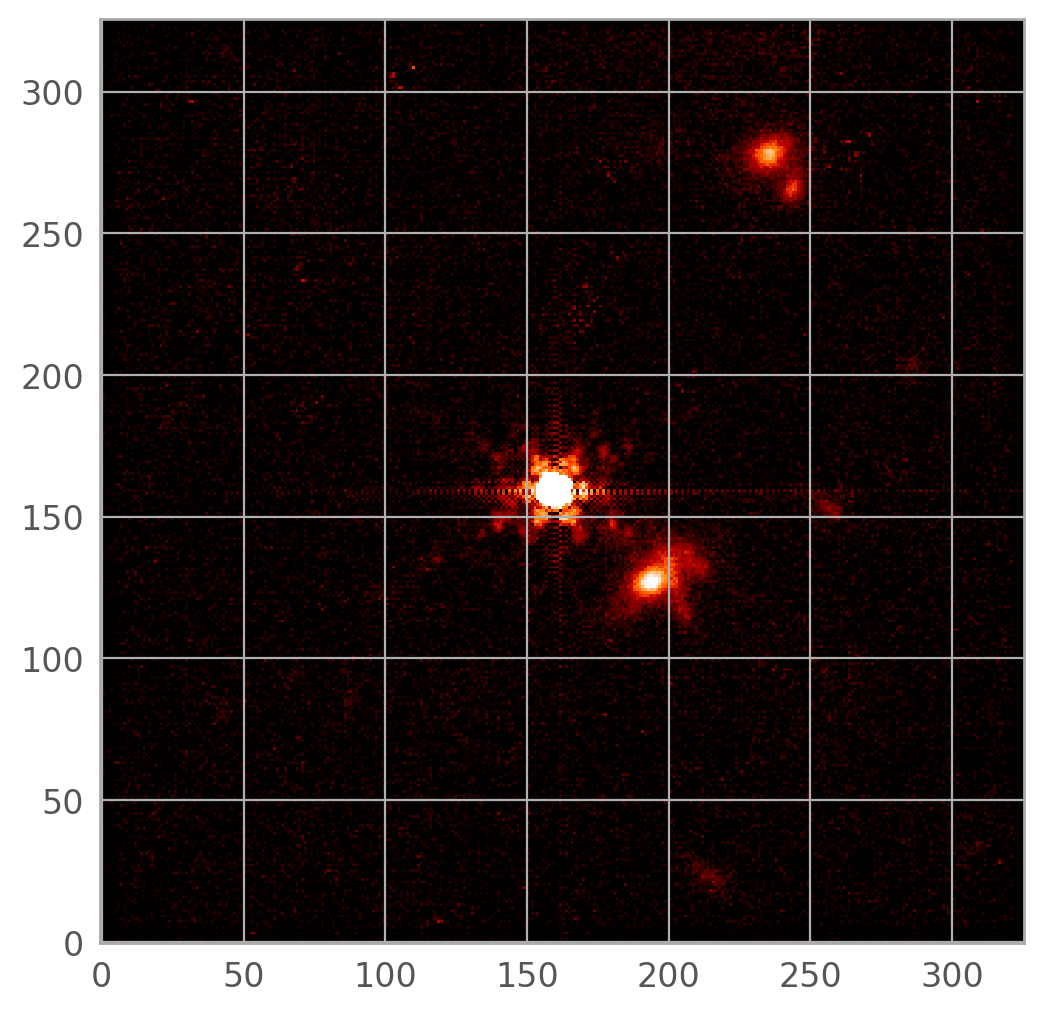

In [71]:
nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB

plt.imshow(stretch(f[:nx_large, :ny_large]))

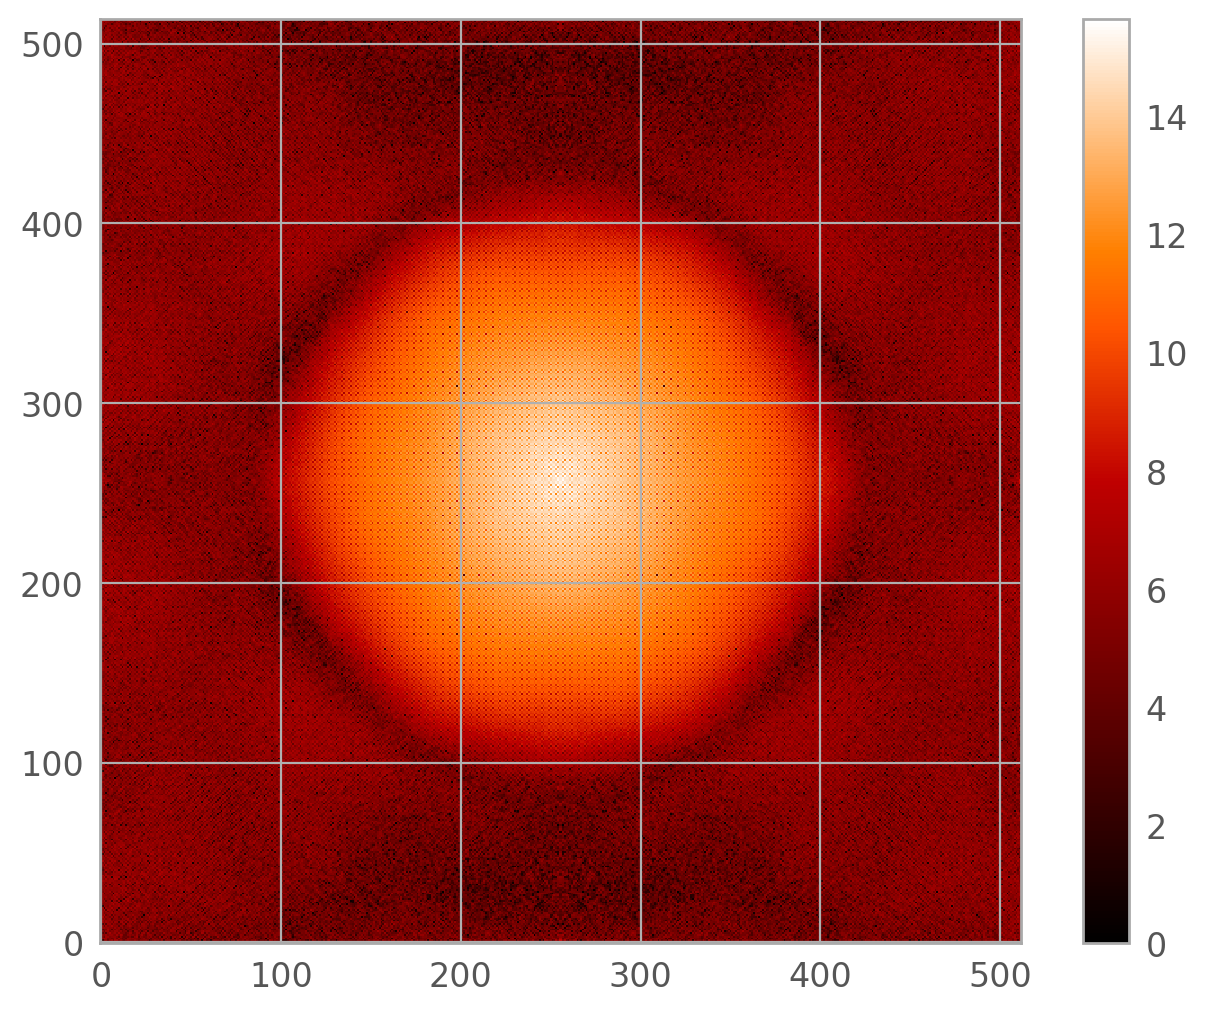

In [51]:
pow = dutils.get_power_spectrum_from_realfft2d(Atotal)
plt.imshow(np.log(pow+1), vmin=0)
plt.colorbar()
plt.show()

In [72]:
# TODO: apply wiener filter to eliminate spikes